# Classifying Suicidality

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import re
from tqdm.auto import tqdm
from utility import clean_reddit_posts, extract_case_features, extract_linguistic_features

# Traditional Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scipy.sparse import hstack, csr_matrix
import joblib

# Determinism
random_seed = 42

np.random.seed(random_seed)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv("cleaned_suicidality_dataset.csv", keep_default_na=False, index_col=0)

df.head()

,title,post,label,has_post,text,text_cleaned,first_person_singular,first_person_plural,absolutist_count,negative_emotion,death_related,past_tense,exclamation_count,question_count,upper_word_count,upper_word_ratio,has_positive_emoji,has_negative_emoji,has_crying_emoji,text_traditional
0,I'm looking for a girl I've met at the Polish ...,I've tried Polish spotted pages but I guess sh...,Non-Suicidal,1,I'm looking for a girl I've met at the Polish ...,I'm looking for a girl I've met at the Polish ...,27,2,0,0,0,3,1,1,4,0.017391,0,0,0,i'm looking for a girl i've met at the polish ...
1,I got a guy kicked off a domestic flight today.,I was in a forward row as we were boarding for...,Non-Suicidal,1,I got a guy kicked off a domestic flight today...,I got a guy kicked off a domestic flight today...,15,3,0,0,0,5,0,1,1,0.004950,0,0,0,i got a guy kicked off a domestic flight today...
2,"My youngest got in school suspension, I’m so p...",So according to witness testimonies a boy grab...,Non-Suicidal,1,"My youngest got in school suspension, I’m so p...","My youngest got in school suspension, I’m so p...",4,2,2,0,0,0,0,0,4,0.050000,0,0,0,"my youngest got in school suspension, i’m so p..."
3,"I'm a cashier who switched from ""sir/mam"" to ""...","So as said in the title, I'm a cashier (well, ...",Non-Suicidal,1,"I'm a cashier who switched from ""sir/mam"" to ""...","I'm a cashier who switched from ""sir/mam"" to ""...",55,4,9,0,0,2,0,0,0,0.000000,1,0,0,"i'm a cashier who switched from ""sir/mam"" to ""..."
4,My whole class complimented me and didn’t real...,"Today in class, we were doing this activity ca...",Non-Suicidal,1,My whole class complimented me and didn’t real...,My whole class complimented me and didn’t real...,15,3,2,0,0,4,0,1,1,0.005435,1,0,0,my whole class complimented me and didn’t real...


In [3]:
dataset = df.drop(["label"], axis=1)
label = df["label"]

## Dataset Split
We will do a standard 80/20 split for train and test.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(dataset, label, train_size=0.8, random_state=random_seed)

In [5]:
label_encoder = LabelEncoder()

# Label encoding target labels
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Mapping of labels to encoding
mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))

## Traditional Machine Learning Models

### Preprocessing
We first encoding the cleaned text data into a form the model can use.

In [6]:
# TF-IDF Encoding Text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
standard_scaler = StandardScaler()

# Trainset and Testset
train_linguistic_features = X_train.loc[:, "first_person_singular": "has_crying_emoji"]
train_text_traditional = X_train["text_traditional"]

test_linguistic_features = X_test.loc[:, "first_person_singular": "has_crying_emoji"]
test_text_traditional = X_test["text_traditional"]

# Encoding datasets
train_linguistic_encoded = csr_matrix(standard_scaler.fit_transform(train_linguistic_features))
test_linguistic_encoded = csr_matrix(standard_scaler.transform(test_linguistic_features))

train_text_encoded = vectorizer.fit_transform(train_text_traditional)
test_text_encoded = vectorizer.transform(test_text_traditional)

# Combined traditional
X_train_trad = hstack((train_text_encoded, train_linguistic_encoded))
X_test_trad = hstack((test_text_encoded, test_linguistic_encoded))

### Classification Baseline Accuracy
Usually, a good baseline is mapping the probability of the process (the model needs to be better than predicting at random). For this dataset, the labels might be imbalanced, so we will use the probability of getting the greater class as our baseline (the model needs to be better than just predicting the major class).

In [7]:
baseline_accuracy = df["label"].value_counts(normalize=True).max()

print(f"The baseline accuracy the models need to beat is {baseline_accuracy*100:.2f}%")

The baseline accuracy the models need to beat is 52.99%


### Logistic Regression
Baseline model for classification

In [8]:
logreg = LogisticRegression(max_iter=1000, random_state=random_seed)
logreg.fit(X_train_trad, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [9]:
initial_accuracy = logreg.score(X_train_trad, y_train)
print(f"Accuracy on the training set is: {initial_accuracy*100:.2f}%")

Accuracy on the training set is: 96.22%


In [10]:
y_predicted = logreg.predict(X_train_trad)
report = classification_report(y_train, y_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      6551
           1       0.97      0.95      0.96      5829

    accuracy                           0.96     12380
   macro avg       0.96      0.96      0.96     12380
weighted avg       0.96      0.96      0.96     12380



#### Hyperparameter Tuning

In [11]:
param_grid_logreg = {
    "penalty": ["l1", "l2"], # Lasso, Ridge, Elasticnet
    "C": np.logspace(-3, 3, 6) # Inverse of lambda
}

# Understand why these are the parameter grid to use.

In [12]:
logreg_cv = GridSearchCV(LogisticRegression(solver="saga", max_iter=1000, random_state=random_seed), param_grid=param_grid_logreg, cv=5, n_jobs=2, return_train_score=True, verbose=1)

logreg_cv.fit(X_train_trad, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


c:\Users\Ezra\OneDrive - De La Salle University - Manila\Documents\DLSU\3rd_Year\Term_2\STINTSY\Notebooks\stintsy\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Ezra\OneDrive - De La Salle University - Manila\Documents\DLSU\3rd_Year\Term_2\STINTSY\Notebooks\stintsy\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...solver='saga')
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': array([1.0000...00000000e+03]), 'penalty': ['l1', 'l2']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",2
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >

In [13]:
logreg_cv_results = pd.DataFrame(logreg_cv.cv_results_)
logreg_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.635980,0.020204,0.002286,0.000410,0.001000,l1,"{'C': 0.001, 'penalty': 'l1'}",0.649031,0.656704,0.674879,...,0.659693,0.009782,12,0.662359,0.660440,0.655897,0.661854,0.657916,0.659693,0.002446
1,0.951391,0.050777,0.001800,0.000264,0.001000,l2,"{'C': 0.001, 'penalty': 'l2'}",0.717690,0.735460,0.739499,...,0.730452,0.009258,11,0.733845,0.730715,0.728393,0.732936,0.731018,0.731381,0.001897
2,26.253169,2.028637,0.002112,0.000379,0.015849,l1,"{'C': 0.015848931924611134, 'penalty': 'l1'}",0.821082,0.829564,0.823910,...,0.825848,0.003122,9,0.825020,0.828655,0.825424,0.825626,0.826939,0.826333,0.001327
3,5.138789,0.575341,0.001957,0.000105,0.015849,l2,"{'C': 0.015848931924611134, 'penalty': 'l2'}",0.819063,0.821082,0.828352,...,0.821325,0.005640,10,0.822597,0.825222,0.822597,0.824011,0.824616,0.823809,0.001061
4,44.049278,6.344456,0.002110,0.000328,0.251189,l1,"{'C': 0.25118864315095796, 'penalty': 'l1'}",0.873183,0.871567,0.869952,...,0.874313,0.003552,8,0.872981,0.876515,0.875404,0.881260,0.875000,0.876232,0.002762
5,22.729287,5.536396,0.001826,0.000089,0.251189,l2,"{'C': 0.25118864315095796, 'penalty': 'l2'}",0.911955,0.909128,0.898223,...,0.907674,0.005350,7,0.912056,0.917205,0.916700,0.919628,0.915489,0.916216,0.002478
6,257.320489,6.270167,0.002276,0.000200,3.981072,l1,"{'C': 3.981071705534969, 'penalty': 'l1'}",0.915590,0.914378,0.905089,...,0.912601,0.005582,6,0.917205,0.920840,0.920436,0.926393,0.920335,0.921042,0.002975
7,19.419695,0.763609,0.001996,0.000397,3.981072,l2,"{'C': 3.981071705534969, 'penalty': 'l2'}",0.920436,0.917205,0.909128,...,0.917609,0.006864,1,0.924071,0.925989,0.926090,0.931947,0.926191,0.926858,0.002663
8,473.722948,24.286510,0.002681,0.000294,63.095734,l1,"{'C': 63.0957344480193, 'penalty': 'l1'}",0.920840,0.917205,0.908724,...,0.917124,0.006619,5,0.924071,0.926595,0.926292,0.932351,0.926797,0.927221,0.002745
9,20.779236,1.488222,0.002033,0.000553,63.095734,l2,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.920840,0.918013,0.908724,...,0.917447,0.006876,2,0.924778,0.926999,0.926494,0.932553,0.927302,0.927625,0.002614


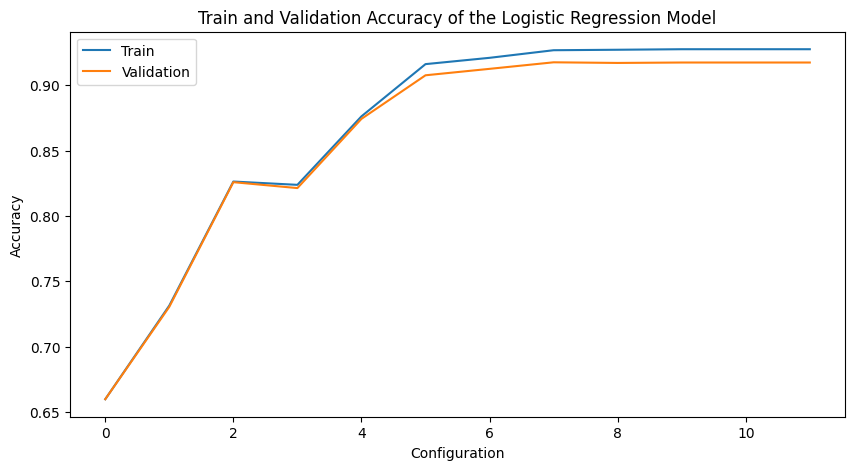

In [14]:
train_scores = logreg_cv_results["mean_train_score"]
validation_scores = logreg_cv_results["mean_test_score"]

fig, ax = plt.subplots(figsize=[10,5])
ax.plot(train_scores, label="Train")
ax.plot(validation_scores, label="Validation")
ax.set_title("Train and Validation Accuracy of the Logistic Regression Model")
ax.set_xlabel("Configuration")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()


In [15]:
best_params = logreg_cv.best_params_
best_C, best_penalty = best_params["C"], best_params["penalty"]

best_C, best_penalty

(np.float64(3.981071705534969), 'l2')

In [16]:
optimized_logreg = LogisticRegression(max_iter=1000, random_state=random_seed, C=best_C, penalty=best_penalty)
optimized_logreg.fit(X_train_trad, y_train)

c:\Users\Ezra\OneDrive - De La Salle University - Manila\Documents\DLSU\3rd_Year\Term_2\STINTSY\Notebooks\stintsy\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'l2'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",np.float64(3.981071705534969)
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.

#### Evaluating on the test set

In [17]:
test_accuracy = optimized_logreg.score(X_test_trad, y_test)
print(f"Accuracy on the training set is: {test_accuracy*100:.2f}%")

Accuracy on the training set is: 94.90%


In [18]:
y_predicted = optimized_logreg.predict(X_test_trad)
report = classification_report(y_test, y_predicted)

print(report)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1650
           1       0.96      0.93      0.94      1446

    accuracy                           0.95      3096
   macro avg       0.95      0.95      0.95      3096
weighted avg       0.95      0.95      0.95      3096



#### Saving Model Parameters

In [23]:
joblib.dump(optimized_logreg, "optimized_logreg.joblib")

['optimized_logreg.joblib']

### Error Analysis

In [50]:
error_bool = y_predicted != y_test
X_test[error_bool]

,title,post,has_post,text,text_cleaned,first_person_singular,first_person_plural,absolutist_count,negative_emotion,death_related,past_tense,exclamation_count,question_count,upper_word_count,upper_word_ratio,has_positive_emoji,has_negative_emoji,has_crying_emoji,text_traditional
9609,The reason I love my bed and sleeping so much ...,,0,The reason I love my bed and sleeping so much ...,The reason I love my bed and sleeping so much ...,3,0,0,0,1,0,0,0,0,0.000000,0,0,0,the reason i love my bed and sleeping so much ...
2458,I am 24 and I am survivor. I beat being morbid...,I just realized today during my daytime dreami...,1,I am 24 and I am survivor. I beat being morbid...,I am 24 and I am survivor. I beat being morbid...,28,0,2,0,1,2,0,0,0,0.000000,0,0,0,i am 24 and i am survivor. i beat being morbid...
11463,It feels so insulting when someone says to see...,As if I hadn’t already.\n\nAnd as if help is e...,1,It feels so insulting when someone says to see...,It feels so insulting when someone says to see...,1,0,0,0,0,0,0,0,0,0.000000,0,0,0,it feels so insulting when someone says to see...
8020,why i love money so much my blood pressure ris...,you don't gonna believe me i love monney than ...,1,why i love money so much my blood pressure ris...,why i love money so much my blood pressure ris...,16,0,1,0,1,0,0,0,0,0.000000,0,0,0,why i love money so much my blood pressure ris...
8296,it's my birthday today,I feel like hanging myself,1,it's my birthday today I feel like hanging myself,it's my birthday today I feel like hanging myself,3,0,0,0,0,0,0,0,0,0.000000,0,0,0,it's my birthday today i feel like hanging myself
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,I wish America had more walkable cities and to...,It sucks living in the middle of nowhere. Why ...,1,I wish America had more walkable cities and to...,I wish America had more walkable cities and to...,2,3,0,0,0,4,0,2,1,0.014493,0,0,0,i wish america had more walkable cities and to...
219,To those with abusive or otherwise terrible mo...,you did nothing to deserve what happened to yo...,1,To those with abusive or otherwise terrible mo...,To those with abusive or otherwise terrible mo...,2,0,2,2,0,1,0,0,0,0.000000,0,0,0,to those with abusive or otherwise terrible mo...
10057,i almost killed myself,but i didn’t. \n\nyay? i guess?\n\ni almost dr...,1,i almost killed myself but i didn’t. \n\nyay? ...,i almost killed myself but i didn’t. yay? i gu...,33,1,0,0,1,5,0,2,12,0.065574,0,0,0,i almost killed myself but i didn’t. yay? i gu...
8292,It got better. Didn’t matter anyway.,For a bit it got better. I thought everyone wa...,1,It got better. Didn’t matter anyway. For a bit...,It got better. Didn’t matter anyway. For a bit...,3,0,1,0,0,4,0,0,0,0.000000,0,0,0,it got better. didn’t matter anyway. for a bit...


In [51]:
y_test[error_bool].shape

(158,)

In [69]:
logreg_errors = pd.concat([X_test[error_bool].reset_index(drop=True), pd.Series(y_test[error_bool], name="label").map(mapping)], axis=1)

In [70]:
logreg_errors

,title,post,has_post,text,text_cleaned,first_person_singular,first_person_plural,absolutist_count,negative_emotion,death_related,past_tense,exclamation_count,question_count,upper_word_count,upper_word_ratio,has_positive_emoji,has_negative_emoji,has_crying_emoji,text_traditional,label
0,The reason I love my bed and sleeping so much ...,,0,The reason I love my bed and sleeping so much ...,The reason I love my bed and sleeping so much ...,3,0,0,0,1,0,0,0,0,0.000000,0,0,0,the reason i love my bed and sleeping so much ...,Suicidal
1,I am 24 and I am survivor. I beat being morbid...,I just realized today during my daytime dreami...,1,I am 24 and I am survivor. I beat being morbid...,I am 24 and I am survivor. I beat being morbid...,28,0,2,0,1,2,0,0,0,0.000000,0,0,0,i am 24 and i am survivor. i beat being morbid...,Non-Suicidal
2,It feels so insulting when someone says to see...,As if I hadn’t already.\n\nAnd as if help is e...,1,It feels so insulting when someone says to see...,It feels so insulting when someone says to see...,1,0,0,0,0,0,0,0,0,0.000000,0,0,0,it feels so insulting when someone says to see...,Suicidal
3,why i love money so much my blood pressure ris...,you don't gonna believe me i love monney than ...,1,why i love money so much my blood pressure ris...,why i love money so much my blood pressure ris...,16,0,1,0,1,0,0,0,0,0.000000,0,0,0,why i love money so much my blood pressure ris...,Non-Suicidal
4,it's my birthday today,I feel like hanging myself,1,it's my birthday today I feel like hanging myself,it's my birthday today I feel like hanging myself,3,0,0,0,0,0,0,0,0,0.000000,0,0,0,it's my birthday today i feel like hanging myself,Suicidal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,I wish America had more walkable cities and to...,It sucks living in the middle of nowhere. Why ...,1,I wish America had more walkable cities and to...,I wish America had more walkable cities and to...,2,3,0,0,0,4,0,2,1,0.014493,0,0,0,i wish america had more walkable cities and to...,Non-Suicidal
154,To those with abusive or otherwise terrible mo...,you did nothing to deserve what happened to yo...,1,To those with abusive or otherwise terrible mo...,To those with abusive or otherwise terrible mo...,2,0,2,2,0,1,0,0,0,0.000000,0,0,0,to those with abusive or otherwise terrible mo...,Non-Suicidal
155,i almost killed myself,but i didn’t. \n\nyay? i guess?\n\ni almost dr...,1,i almost killed myself but i didn’t. \n\nyay? ...,i almost killed myself but i didn’t. yay? i gu...,33,1,0,0,1,5,0,2,12,0.065574,0,0,0,i almost killed myself but i didn’t. yay? i gu...,Suicidal
156,It got better. Didn’t matter anyway.,For a bit it got better. I thought everyone wa...,1,It got better. Didn’t matter anyway. For a bit...,It got better. Didn’t matter anyway. For a bit...,3,0,1,0,0,4,0,0,0,0.000000,0,0,0,it got better. didn’t matter anyway. for a bit...,Suicidal


In [71]:
logreg_errors_features = logreg_errors[["has_post", *list(logreg_errors.loc[:,"first_person_singular": "has_crying_emoji"].columns)]]

In [73]:
suicidal_bool = logreg_errors["label"] == "Suicidal"
non_suicidal_bool = logreg_errors["label"] == "Non-Suicidal"


#### Exploring suicidal errors

In [77]:
logreg_errors_features[suicidal_bool].describe()

,has_post,first_person_singular,first_person_plural,absolutist_count,negative_emotion,death_related,past_tense,exclamation_count,question_count,upper_word_count,upper_word_ratio,has_positive_emoji,has_negative_emoji,has_crying_emoji
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.0,97.0
mean,0.865979,10.288660,0.824742,1.659794,0.319588,0.247423,2.412371,0.298969,0.670103,0.989691,0.005553,0.082474,0.0,0.0
std,0.342444,11.546968,2.245413,2.414740,0.621597,0.521035,4.147671,1.191681,1.367187,5.233097,0.018624,0.276515,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,1.000000,6.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,1.000000,15.000000,1.000000,2.000000,0.000000,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0
max,1.000000,47.000000,18.000000,12.000000,3.000000,2.000000,28.000000,8.000000,7.000000,49.000000,0.137640,1.000000,0.0,0.0


In [84]:
error_sample = logreg_errors.loc[suicidal_bool, "text_cleaned"].sample(5, random_state=random_seed).reset_index(drop=True)

In [87]:
for text in error_sample:
    print(text)

People really don't realise how much their comments hurt. Knew a girl that I used to be really good friends with for years and fell in love with. Nothing serious ever came from it. Just matched with her on tinder tonight, and she messaged within the first minute, saying "I hope you know this was a joke" This is it boys, goodnight.
Dream In a dream i saw my mother with the love of her life and no children, i have never seen her this happy.
Attempted su!c!de yesterday well it didnt go as planned i guess the suffering keeps going on🙁💔 
I jus bought new razor blades and I cant wait to use them 
I finally told my husband how I’ve been struggling recently and... ...he said, “Well, just go find something else to do. I mean, I’ve watched you become more and more withdrawn and isolating yourself from the outside world. Just go find a group of people to be around. Maybe that’ll help.” Jesus fucking Christ. I wish it was that easy.


Based on the random sample, here are some of the things that was noticed.
1. The preprocessing falls short on "censorship", Reddit posters often censor words creatively, "suicide" to "su!c!de", "die" to "unalive." 
2. Some of the false negatives are context-heavy in their suicidality. For example, the meion of razor blades can mean other things, but in this case it means self harm. The dream post inherently doesn't seem "suicida" as well, but in context it can be considered such. TF-IDF falls short in this area as there's no semantic mapping, only frequency indicators.
3. Current feature engineering does not account for unicode emojis, only "emoticons" like :( or :)

In [90]:
#TODO add improvements and move on.